<h1> Assignment 3 Group 10 - Magnification 400 </h1>

In [1]:
import tarfile
import pandas as pd
import os

Import Data to DataFrame, include Benign/Malignant with ID, Choose a Magnification

In [2]:
def extract_image_labels(folder_path, magnification_lvl): 
    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == str(magnification_lvl):
                    labels.append(label)
                    file_paths.append(file_path)
    
    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df

In [3]:
image_labels_df = extract_image_labels("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1", 400) # change mangification level here

In [4]:
image_labels_df.head(5)

,FilePath,Label
0,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
1,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
2,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
3,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
4,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M


Split Data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1274, 2)
The shape of test data (273, 2)
The shape of validation data (273, 2)


In [7]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

Visualize Distribution of Train, Test, Validation Data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_12827/3967762231.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire').set_title('Class distribution in Training set',fontsize=15)
/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_12827/3967762231.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire').set_title('Class distribution in validation set',fontsize=15)
/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_12827/3967762231.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable 

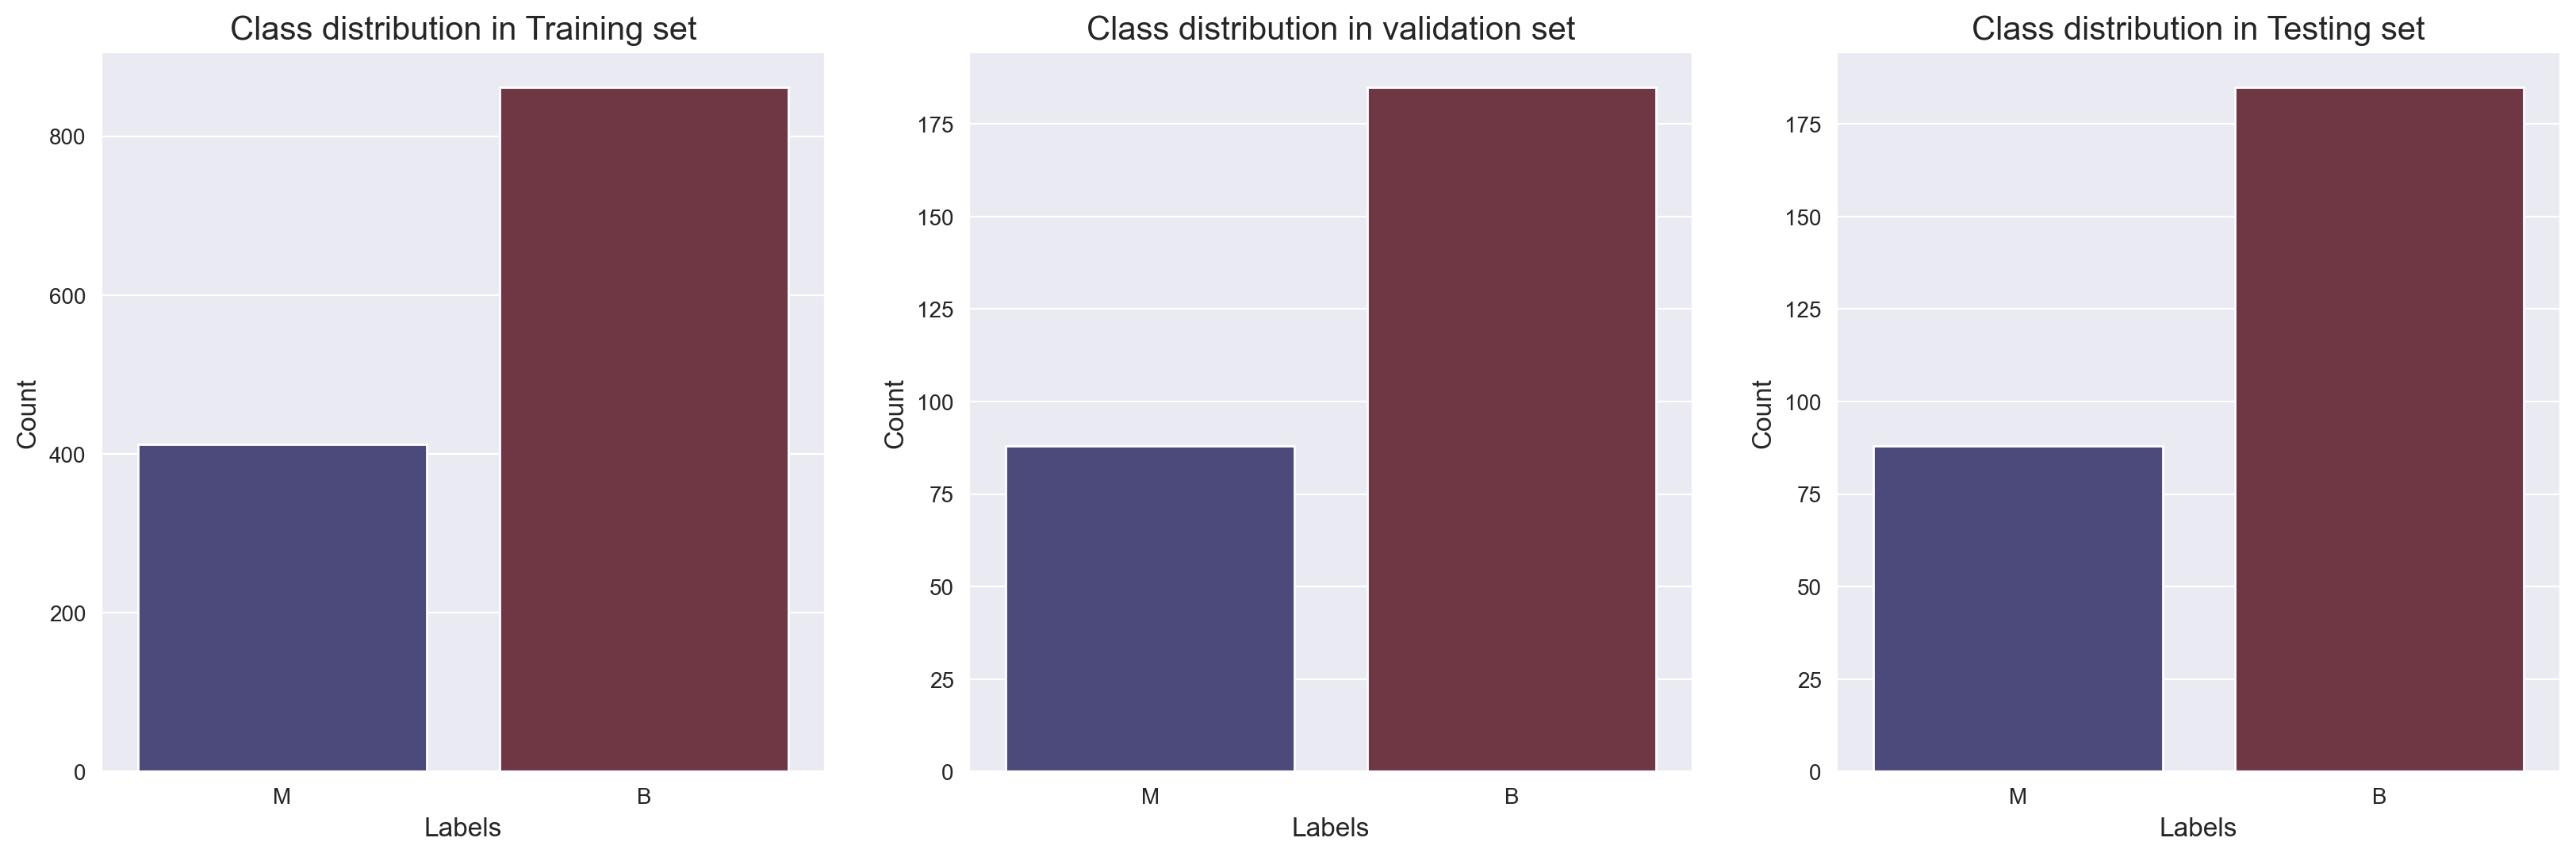

In [9]:
labels = ['M','B']

label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire').set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire').set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire').set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

Implement at least three Deep Learning based classifiers: One needs to be a CNN, one can be a shallow neural network, e.g. a fully connected NN with one hidden layer.

In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall


CNN

In [11]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [12]:
base_dir = "/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1"

In [13]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

Data Augmentation

In [14]:
# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),        # Rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.2),            # Zoom up to 20%
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

2024-11-11 17:39:23.390530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = (create_dataset(train_filepaths, train_labels)
            .shuffle(buffer_size=len(train_filepaths))
            .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.experimental.AUTOTUNE))
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [18]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
40/40 [==============================] - 4s 30ms/step - loss: 0.5618 - accuracy: 0.7096 - precision: 0.7193 - recall: 0.9362 - val_loss: 0.4328 - val_accuracy: 0.8168 - val_precision: 0.8729 - val_recall: 0.8541
Epoch 2/10
40/40 [==============================] - 3s 23ms/step - loss: 0.5044 - accuracy: 0.7614 - precision: 0.7870 - recall: 0.8875 - val_loss: 0.4745 - val_accuracy: 0.7582 - val_precision: 0.7390 - val_recall: 0.9946
Epoch 3/10
40/40 [==============================] - 3s 23ms/step - loss: 0.4638 - accuracy: 0.8116 - precision: 0.8267 - recall: 0.9130 - val_loss: 0.3735 - val_accuracy: 0.8608 - val_precision: 0.8483 - val_recall: 0.9676
Epoch 4/10
40/40 [==============================] - 3s 20ms/step - loss: 0.4411 - accuracy: 0.8250 - precision: 0.8353 - recall: 0.9234 - val_loss: 0.3468 - val_accuracy: 0.8791 - val_precision: 0.8762 - val_recall: 0.9568
Epoch 5/10
40/40 [==============================] - 2s 20ms/step - loss: 0.4833 - accuracy: 0.7951 - precisi

Evaluation

In [19]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

9/9 [==============================] - 0s 40ms/step - loss: 0.4966 - accuracy: 0.7839 - precision: 0.8750 - recall: 0.7946
Loss: 0.49659568071365356
Accuracy: 0.7838827967643738
Precision: 0.875
Recall(Sensitivity): 0.7945945858955383


<h3>Fully connected NN with one hidden layer </h3>

In [20]:
model_2 = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),  # fully connected -> flatten from 2D to 1D
    layers.Dense(64, activation='relu'),  # hidden layer -> learning features from the input data
    layers.Dense(1, activation='sigmoid') 
])

In [21]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [22]:
history_2 = model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
40/40 [==============================] - 3s 18ms/step - loss: 0.6978 - accuracy: 0.6452 - precision_1: 0.7214 - recall_1: 0.7749 - val_loss: 0.5096 - val_accuracy: 0.6777 - val_precision_1: 0.6777 - val_recall_1: 1.0000
Epoch 2/10
40/40 [==============================] - 2s 11ms/step - loss: 0.5348 - accuracy: 0.7323 - precision_1: 0.7522 - recall_1: 0.9014 - val_loss: 0.5903 - val_accuracy: 0.6374 - val_precision_1: 0.9300 - val_recall_1: 0.5027
Epoch 3/10
40/40 [==============================] - 2s 13ms/step - loss: 0.5065 - accuracy: 0.7755 - precision_1: 0.7975 - recall_1: 0.8956 - val_loss: 0.4299 - val_accuracy: 0.8535 - val_precision_1: 0.8311 - val_recall_1: 0.9838
Epoch 4/10
40/40 [==============================] - 2s 12ms/step - loss: 0.5075 - accuracy: 0.7951 - precision_1: 0.8166 - recall_1: 0.8991 - val_loss: 0.7004 - val_accuracy: 0.5751 - val_precision_1: 0.9157 - val_recall_1: 0.4108
Epoch 5/10
40/40 [==============================] - 2s 13ms/step - loss: 0.5

In [23]:
results_2 = model_2.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_2)):
    print(metrics[i] + ': ' + str(results_2[i]))

9/9 [==============================] - 0s 41ms/step - loss: 0.5055 - accuracy: 0.8059 - precision_1: 0.8267 - recall_1: 0.9027
Loss: 0.5055143237113953
Accuracy: 0.8058608174324036
Precision: 0.8267326951026917
Recall(Sensitivity): 0.9027026891708374


<h3>ResNet-50 </h3>

In [24]:
from tensorflow.keras.applications import ResNet50

In [25]:
IMG_SIZE_resnet = (224, 224) #ResNet50 input size requirement

def load_and_preprocess_image_resnet(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE_resnet)
    image = tf.keras.applications.resnet50.preprocess_input(image) #ResNet preprocessing
    return image

In [26]:
def create_dataset_resnet(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels for ResNet
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [27]:
# Shuffle, batch, and prefetch the datasets
train_ds_resnet = (create_dataset_resnet(train_filepaths, train_labels)
                   .shuffle(buffer_size=len(train_filepaths))
                   .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.experimental.AUTOTUNE))
val_ds_resnet = create_dataset_resnet(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds_resnet = create_dataset_resnet(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #without the top classification layer to add custom classification layers later
base_model.trainable = False  #freeze base model to avoid fine tuning

In [29]:
model_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #reduce output to single vector
    layers.Dense(1, activation='sigmoid')  
])

In [30]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [31]:
history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=10)

Epoch 1/10
40/40 [==============================] - 72s 2s/step - loss: 0.4939 - accuracy: 0.7622 - precision_2: 0.7809 - recall_2: 0.9014 - val_loss: 0.3241 - val_accuracy: 0.8974 - val_precision_2: 0.8945 - val_recall_2: 0.9622
Epoch 2/10
40/40 [==============================] - 69s 2s/step - loss: 0.3606 - accuracy: 0.8493 - precision_2: 0.8618 - recall_2: 0.9258 - val_loss: 0.2609 - val_accuracy: 0.9121 - val_precision_2: 0.9259 - val_recall_2: 0.9459
Epoch 3/10
40/40 [==============================] - 71s 2s/step - loss: 0.3225 - accuracy: 0.8658 - precision_2: 0.8801 - recall_2: 0.9281 - val_loss: 0.2342 - val_accuracy: 0.9194 - val_precision_2: 0.9358 - val_recall_2: 0.9459
Epoch 4/10
40/40 [==============================] - 72s 2s/step - loss: 0.2926 - accuracy: 0.8854 - precision_2: 0.8917 - recall_2: 0.9455 - val_loss: 0.2337 - val_accuracy: 0.9231 - val_precision_2: 0.9659 - val_recall_2: 0.9189
Epoch 5/10
40/40 [==============================] - 71s 2s/step - loss: 0.2694 -

In [32]:
#fine tuning
base_model.trainable = True
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  #lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=5)

Epoch 1/5
40/40 [==============================] - 261s 6s/step - loss: 0.3945 - accuracy: 0.8226 - precision_3: 0.8907 - recall_3: 0.8411 - val_loss: 0.1810 - val_accuracy: 0.9158 - val_precision_3: 0.9133 - val_recall_3: 0.9676
Epoch 2/5
40/40 [==============================] - 247s 6s/step - loss: 0.2605 - accuracy: 0.8917 - precision_3: 0.9269 - recall_3: 0.9118 - val_loss: 0.1775 - val_accuracy: 0.9231 - val_precision_3: 0.9227 - val_recall_3: 0.9676
Epoch 3/5
40/40 [==============================] - 246s 6s/step - loss: 0.2165 - accuracy: 0.9278 - precision_3: 0.9425 - recall_3: 0.9513 - val_loss: 0.1629 - val_accuracy: 0.9267 - val_precision_3: 0.9231 - val_recall_3: 0.9730
Epoch 4/5
40/40 [==============================] - 246s 6s/step - loss: 0.1871 - accuracy: 0.9309 - precision_3: 0.9459 - recall_3: 0.9524 - val_loss: 0.1424 - val_accuracy: 0.9341 - val_precision_3: 0.9282 - val_recall_3: 0.9784
Epoch 5/5
40/40 [==============================] - 251s 6s/step - loss: 0.1610 -

In [33]:
results_3 = model_3.evaluate(test_ds_resnet)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_3)):
    print(metrics[i] + ': ' + str(results_3[i]))

9/9 [==============================] - 12s 1s/step - loss: 0.2784 - accuracy: 0.8974 - precision_3: 0.8829 - recall_3: 0.9784
Loss: 0.27840954065322876
Accuracy: 0.8974359035491943
Precision: 0.8829268217086792
Recall(Sensitivity): 0.9783783555030823


<h3>Plots</h3>

<h3>Metric Comparison</h3>

In [34]:
results = np.array(results)
results_2 = np.array(results_2)
results_3 = np.array(results_3)
results_df = pd.DataFrame({'CNN': results, 'Shallow NN': results_2, 'ResNet50': results_3})

results_df = results_df.T

results_df.columns = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
results_df

,Loss,Accuracy,Precision,Recall(Sensitivity)
CNN,0.496596,0.783883,0.875000,0.794595
Shallow NN,0.505514,0.805861,0.826733,0.902703
ResNet50,0.278410,0.897436,0.882927,0.978378


<Figure size 1440x1080 with 0 Axes>

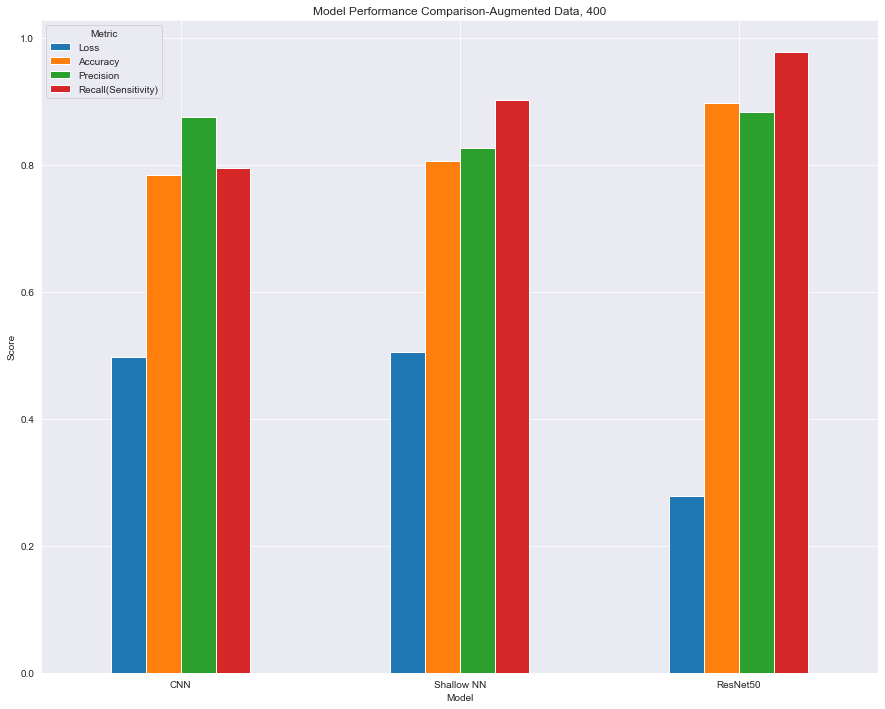

In [35]:
plt.figure(figsize=(20, 15))

results_df.plot(kind='bar', rot=0, figsize=(15,12))
plt.title('Model Performance Comparison-Augmented Data, 400')
plt.ylabel('Score')
plt.xlabel('Model')  

# Show the plot
plt.legend(title='Metric')
plt.show()

<h3>ROC Curves</h3>

In [36]:
from sklearn.metrics import roc_curve, auc

In [37]:
X_test_images = np.array([load_and_preprocess_image(fp) for fp in X_test['FilePath']])
X_test_images_resnet = np.array([load_and_preprocess_image_resnet(fp) for fp in X_test['FilePath']])

probabilities_CNN = model.predict(X_test_images)
probabilities_ShallowNN = model_2.predict(X_test_images)
probabilities_ResNet50 = model_3.predict(X_test_images_resnet)

9/9 [==============================] - 13s 1s/step


In [38]:
fpr_CNN, tpr_CNN, _ = roc_curve(test_labels, probabilities_CNN)
fpr_ShallowNN, tpr_ShallowNN, _ = roc_curve(test_labels, probabilities_ShallowNN)
fpr_ResNet50, tpr_ResNet50, _ = roc_curve(test_labels, probabilities_ResNet50)

auc_CNN = auc(fpr_CNN, tpr_CNN)
auc_ShallowNN = auc(fpr_ShallowNN, tpr_ShallowNN)
auc_ResNet50 = auc(fpr_ResNet50, tpr_ResNet50)

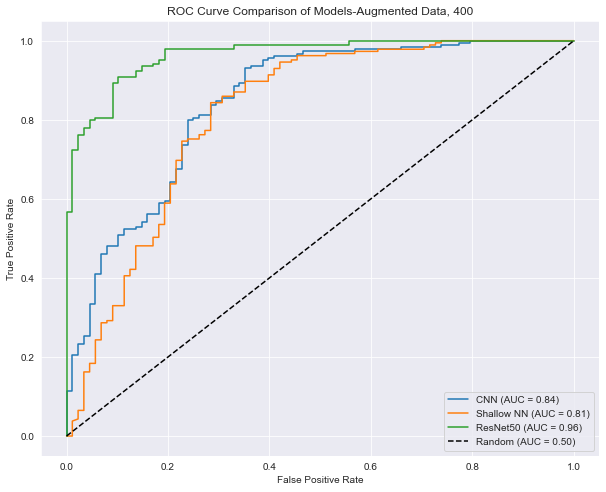

In [39]:
plt.figure(figsize=(10, 8))


plt.plot(fpr_CNN, tpr_CNN, label=f'CNN (AUC = {auc_CNN:.2f})')
plt.plot(fpr_ShallowNN, tpr_ShallowNN, label=f'Shallow NN (AUC = {auc_ShallowNN:.2f})')
plt.plot(fpr_ResNet50, tpr_ResNet50, label=f'ResNet50 (AUC = {auc_ResNet50:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models-Augmented Data, 400')
plt.legend(loc='lower right')
plt.show()

<h3>Confusion Matrix</h3>

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
#probabilities to binary predictions
pred_CNN = (probabilities_CNN > 0.5).astype(int)
pred_ShallowNN = (probabilities_ShallowNN > 0.5).astype(int)
pred_ResNet50 = (probabilities_ResNet50 > 0.5).astype(int)

In [42]:
cm_CNN = confusion_matrix(test_labels, pred_CNN)
cm_ShallowNN = confusion_matrix(test_labels, pred_ShallowNN)
cm_ResNet50 = confusion_matrix(test_labels, pred_ResNet50)

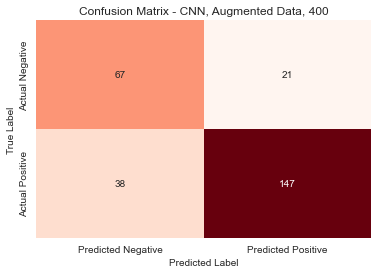

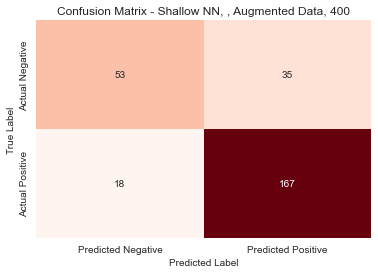

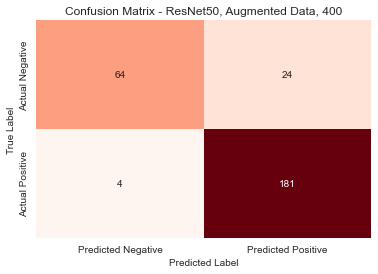

In [43]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_CNN, "Confusion Matrix - CNN, Augmented Data, 400")
plot_confusion_matrix(cm_ShallowNN, "Confusion Matrix - Shallow NN, , Augmented Data, 400")
plot_confusion_matrix(cm_ResNet50, "Confusion Matrix - ResNet50, Augmented Data, 400")

<h3>Learning Curves</h3>

<h3>Training/Validation Accuracy </h3>

In [44]:
def plot_accuracy(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

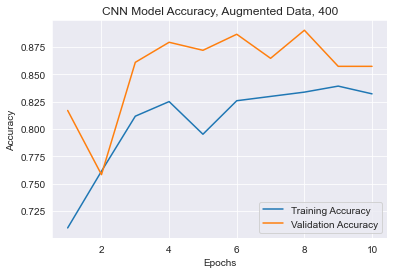

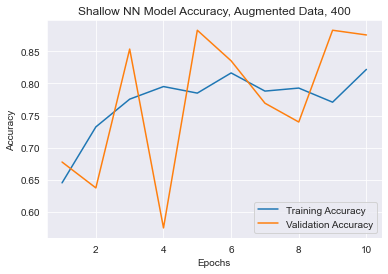

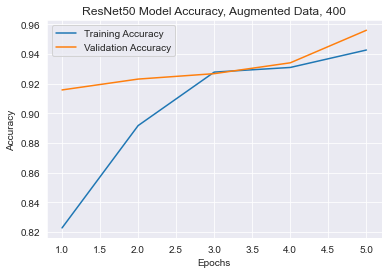

In [45]:
plot_accuracy(history, 'CNN Model Accuracy, Augmented Data, 400')
plot_accuracy(history_2, 'Shallow NN Model Accuracy, Augmented Data, 400')
plot_accuracy(history_3, 'ResNet50 Model Accuracy, Augmented Data, 400')

<h3>Training/Validation Loss </h3>

In [46]:
def plot_loss(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

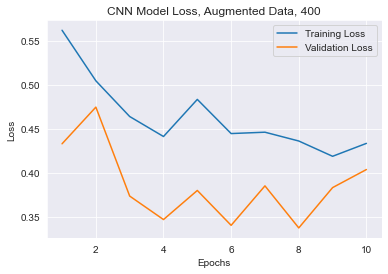

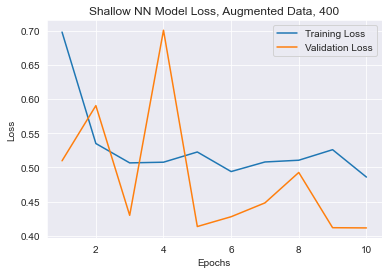

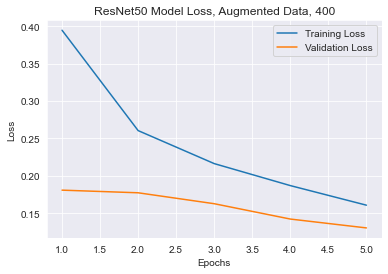

In [47]:
plot_loss(history, 'CNN Model Loss, Augmented Data, 400')
plot_loss(history_2, 'Shallow NN Model Loss, Augmented Data, 400')
plot_loss(history_3, 'ResNet50 Model Loss, Augmented Data, 400')